In [1]:
import matplotlib
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import keras
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import pickle
import os
from helper_deep import *
from models import *

from keras import backend as K

%matplotlib inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
# We don't change these values
NB_LABELS = 2
NB_CHANNELS = 3
PATCH_SIZE = 16
TRAINING_IMGS_SIZE = 400
TEST_IMGS_SIZE = 608
SEED = 0

In [3]:
# We play with these values
NB_IMAGES_TO_LOAD = 100
TRAINING_SET_SIZE = 0.8
BATCH_SIZE = 64

In [4]:
# Load a set of images
root_dir = "Datasets/training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
imgs = [load_image(image_dir + files[i]) for i in range(NB_IMAGES_TO_LOAD)]

gt_dir = root_dir + "groundtruth/"
gt_imgs = [load_image(gt_dir + files[i]) for i in range(NB_IMAGES_TO_LOAD)]

angles = [23,121,236,327]

rotated_imgs = get_rotated_images(imgs, angles)
rotated_gt_imgs = get_rotated_images(gt_imgs, angles)

imgs = imgs + rotated_imgs
gt_imgs = gt_imgs + rotated_gt_imgs

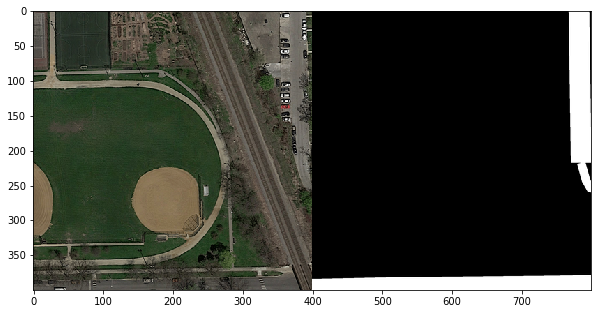

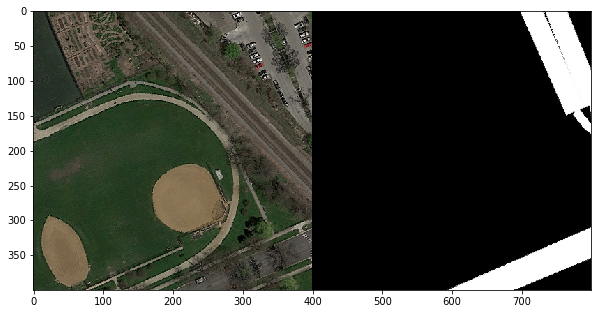

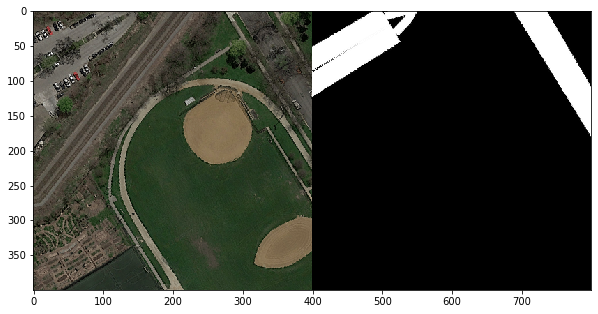

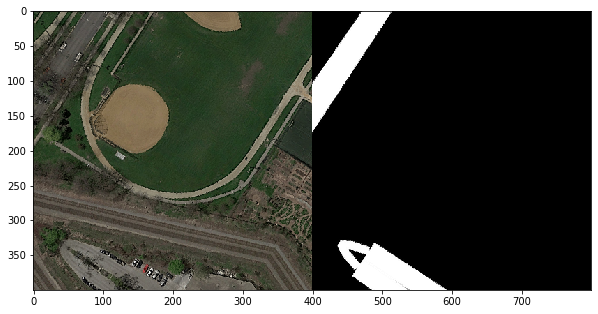

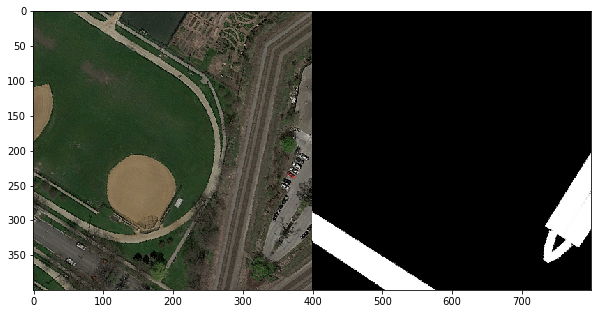

In [5]:
img_idx = 0
for i in np.array([0, 100, 200, 300, 400]) + img_idx:
    print_img_and_gt_img(imgs, gt_imgs, [i])

In [6]:
img_patches, gt_patches = extract_patches(imgs, gt_imgs, PATCH_SIZE)
img_patches.shape, gt_patches.shape

((312500, 16, 16, 3), (312500, 16, 16))

In [7]:
X = standardize_color_features(img_patches)
y = np.asarray([value_to_class(np.mean(gt_patches[i])) for i in range(len(gt_patches))])
X.shape, y.shape

((312500, 16, 16, 3), (312500, 2))

In [8]:
# X, y = balance_data(X, y)

In [9]:
X_train, y_train, X_val, y_val = split_data(X, y, TRAINING_SET_SIZE, SEED)
X_train.shape, y_train.shape

((250000, 16, 16, 3), (250000, 2))

In [10]:
from sklearn.utils import class_weight

y_train_1d = np.argmax(y_train, axis=1)
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train_1d), y_train_1d)

In [11]:
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_val = lb.transform(y_val)
y_train.shape

(250000, 2)

In [12]:
model = U_Net.build(width=PATCH_SIZE, height=PATCH_SIZE, nb_channels=NB_CHANNELS, nb_labels=NB_LABELS)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16, 16, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 16, 16, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 16, 16, 16)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [14]:
EPOCHS = 3

opt = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=['binary_accuracy'])

In [15]:
# train the neural network
H = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=EPOCHS, batch_size=BATCH_SIZE, class_weight=class_weights)

Train on 250000 samples, validate on 62500 samples
Epoch 1/3
250000/250000 [==============================] - 1432s 6ms/step - loss: 0.3955 - binary_accuracy: 0.8132 - val_loss: 0.3598 - val_binary_accuracy: 0.8324
Epoch 2/3
250000/250000 [==============================] - 1383s 6ms/step - loss: 0.3573 - binary_accuracy: 0.8340 - val_loss: 0.3347 - val_binary_accuracy: 0.8447
Epoch 3/3
250000/250000 [==============================] - 1378s 6ms/step - loss: 0.3362 - binary_accuracy: 0.8456 - val_loss: 0.3235 - val_binary_accuracy: 0.8506


In [16]:
model.save('Models/unet_3.h5')
# new_model = keras.models.load_model('Models/model_name.h5')

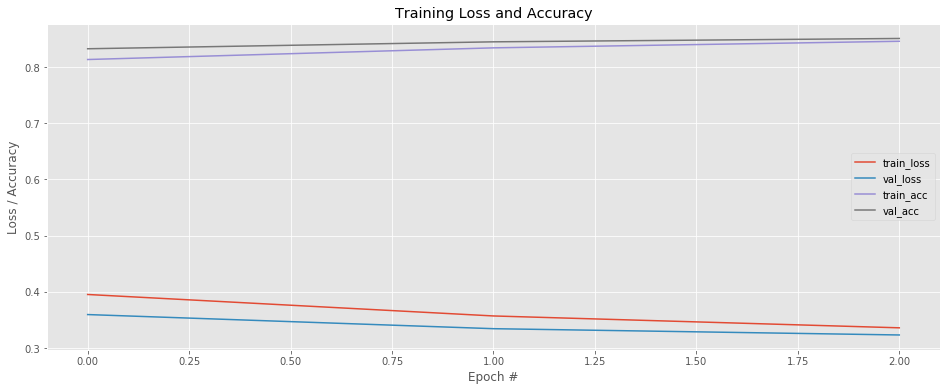

In [18]:
# plot the training loss and accuracy
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure(figsize=(16,6))
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["binary_accuracy"], label="train_acc")
plt.plot(N, H.history["val_binary_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss / Accuracy")
plt.legend()

In [19]:
# Data to evaluate
root_testdir = "Datasets/test_set_images"
test_names = os.listdir(root_testdir)

prefixes = ('.')
for dir_ in test_names[:]:
    if dir_.startswith(prefixes):
        test_names.remove(dir_)
        
num_test = len(test_names)

#get data permutation
order = [int(test_names[i].split("_")[1]) for i in range(num_test)]
p = np.argsort(order)

imgs_test = [load_image(os.path.join(root_testdir, test_names[i], test_names[i]) + ".png") for i in range(num_test)]
#order data
imgs_test = [imgs_test[i] for i in p]

In [20]:
img_test_patches = extract_patches_testing(imgs_test, PATCH_SIZE)
img_test_patches.shape

(72200, 16, 16, 3)

In [21]:
X_test = standardize_color_features(img_test_patches)
X_test.shape

(72200, 16, 16, 3)

In [22]:
predictions = np.argmax(model.predict(X_test, batch_size=BATCH_SIZE), axis=1)
print(predictions)

[0 1 1 ... 0 0 0]


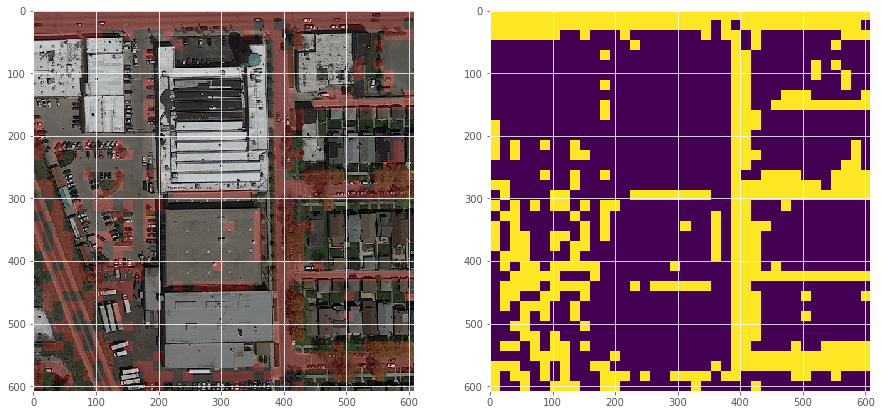

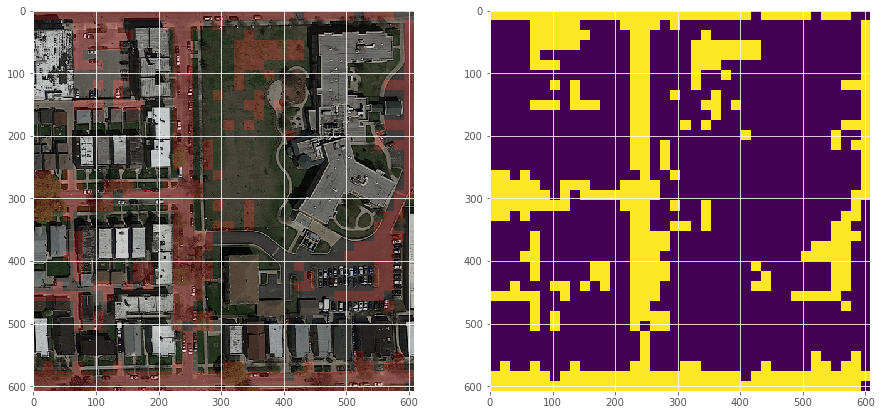

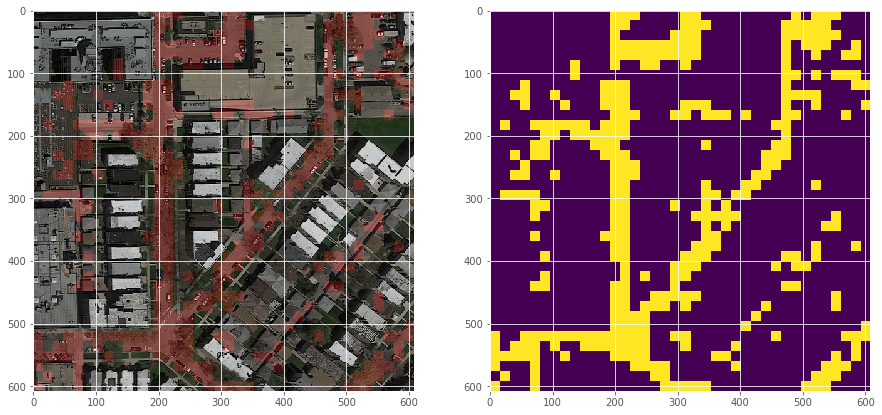

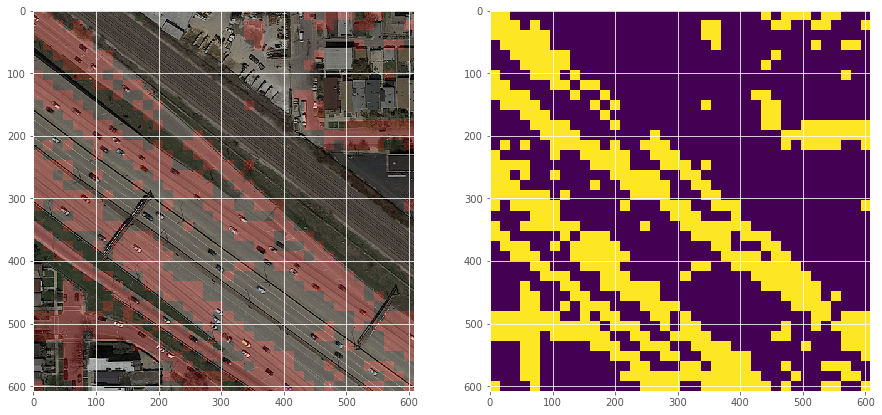

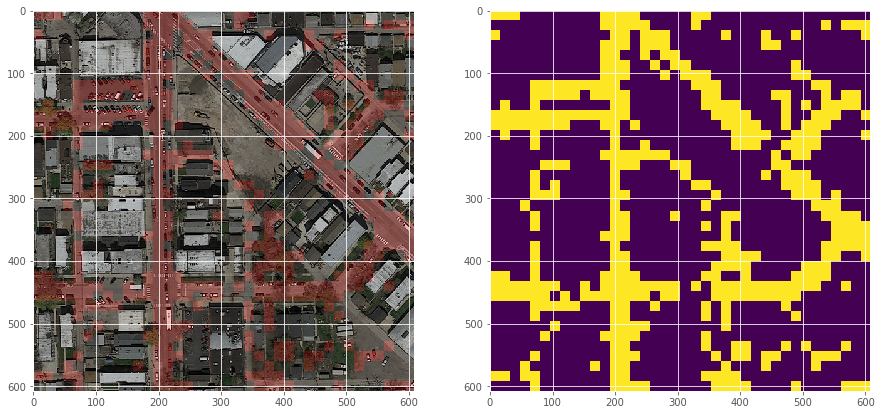

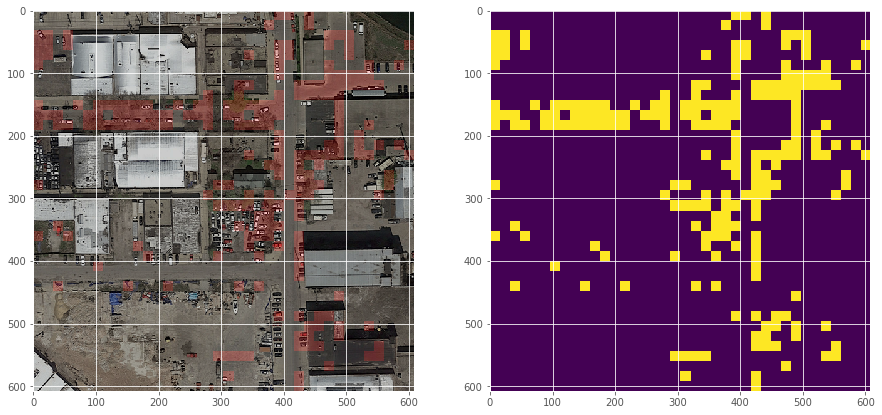

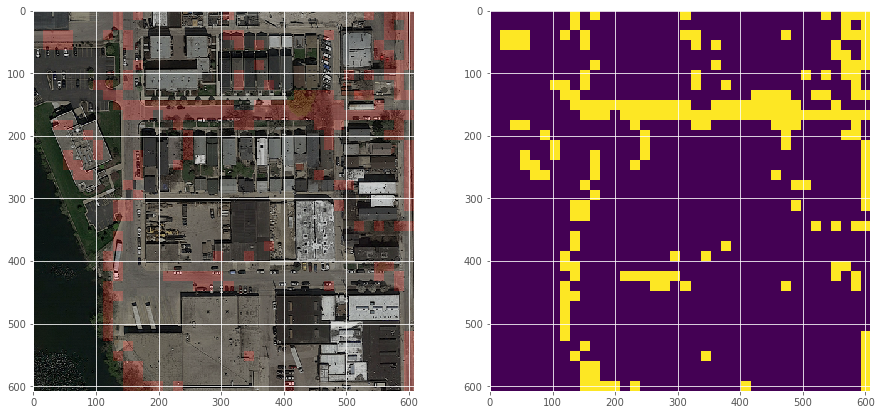

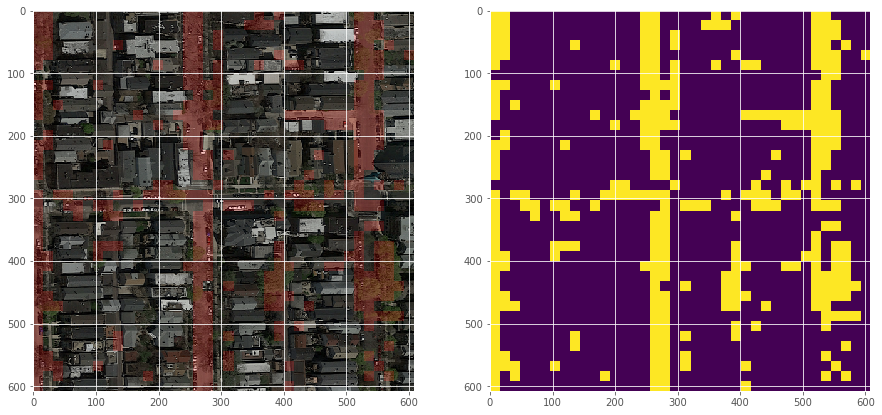

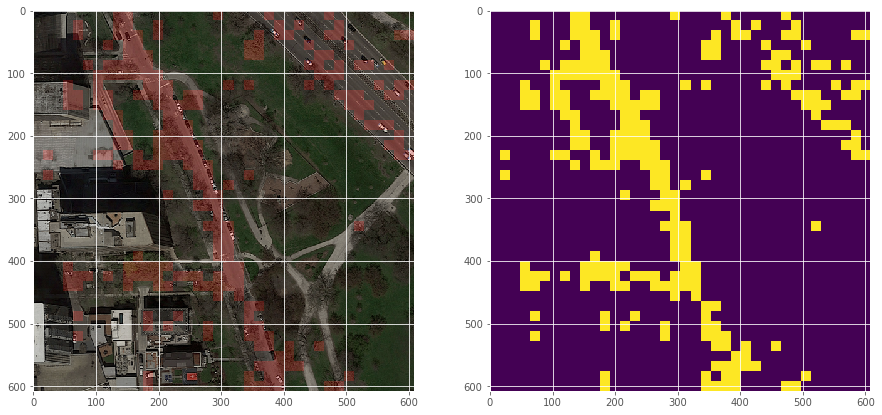

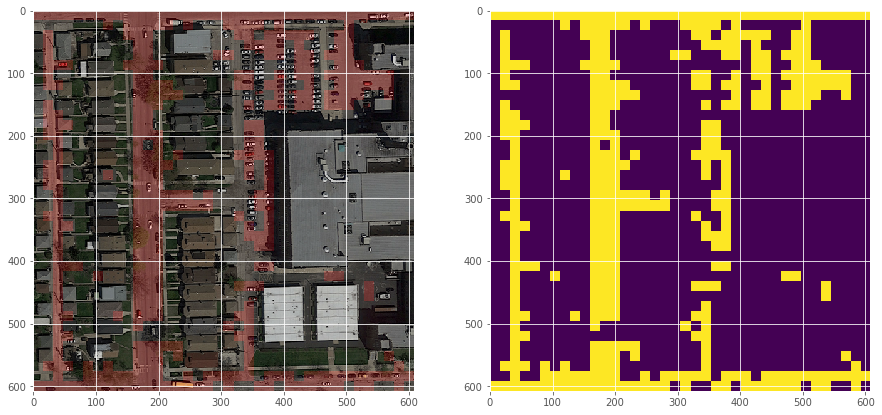

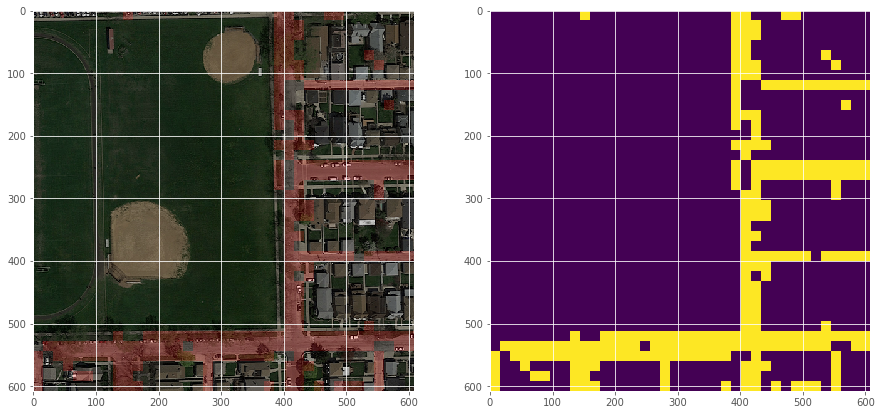

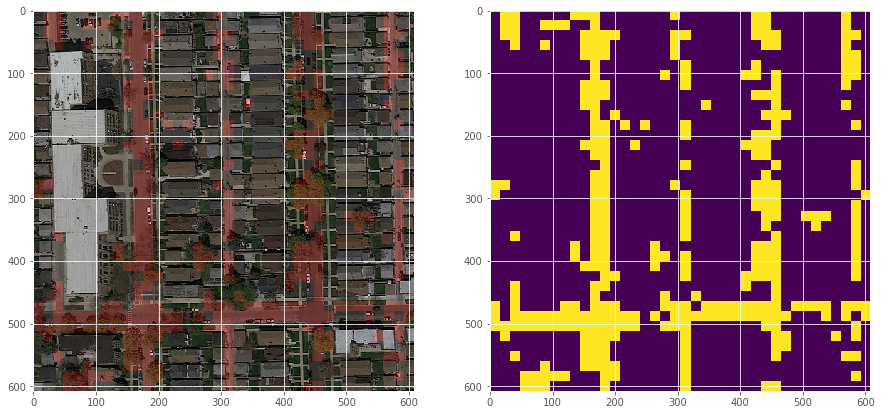

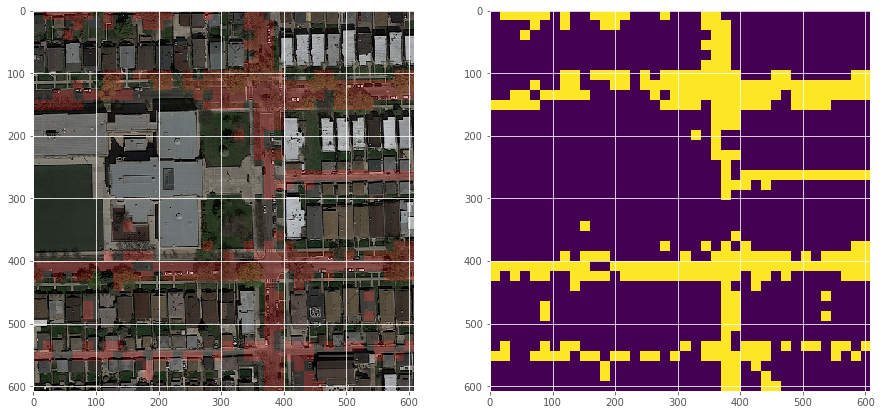

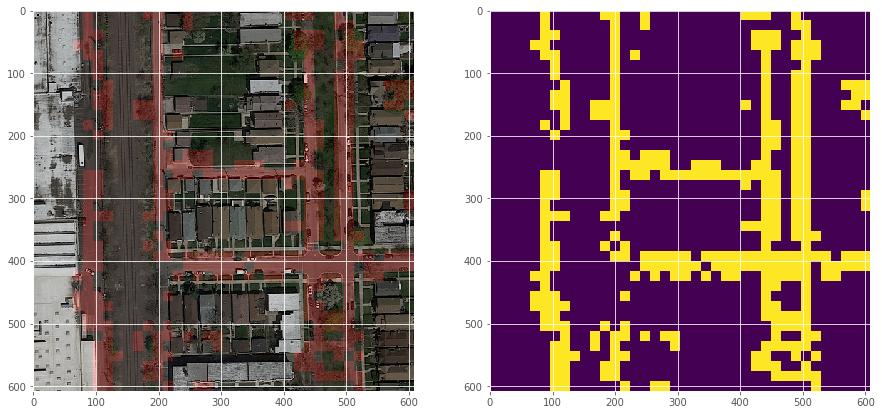

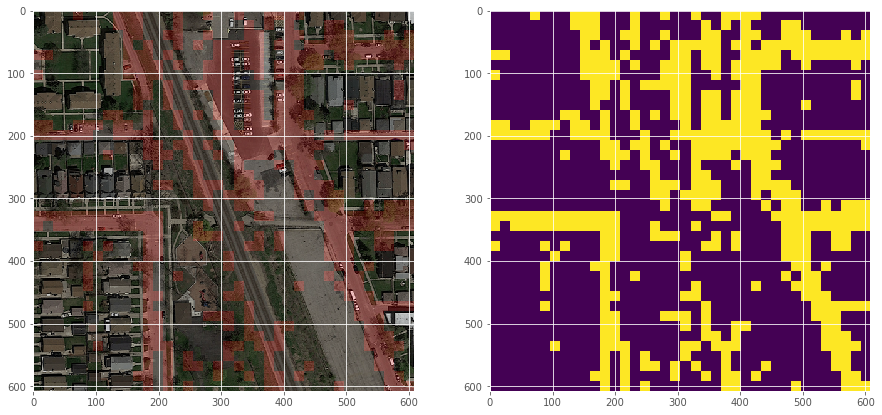

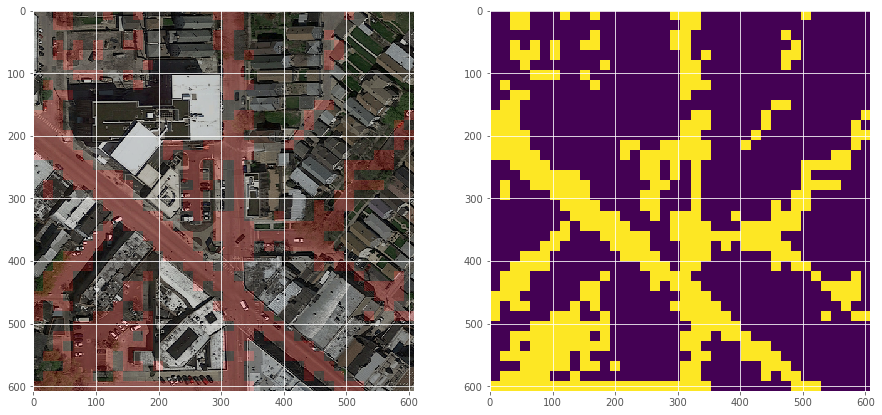

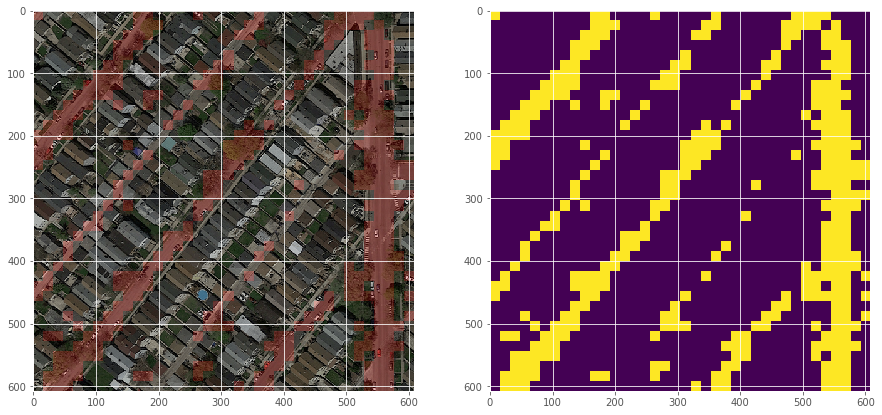

In [23]:
#choose image index
nb_patches_per_img = TEST_IMGS_SIZE // PATCH_SIZE
interesting_ids = [2, 3, 4, 9, 11, 12, 13, 21, 26, 32, 33, 36, 41, 43, 45, 49, 50]
for img_idx in np.array(interesting_ids) - 1:

    # predict labels for image
    labels = predictions[img_idx*(nb_patches_per_img**2):(img_idx+1)*(nb_patches_per_img**2)]

    # Display prediction as an image
    w = imgs_test[img_idx].shape[0]
    h = imgs_test[img_idx].shape[1]
    predicted_im = label_to_img(w, h, PATCH_SIZE, PATCH_SIZE, labels)
    fig1 = plt.figure(figsize=(15, 15)) 
    new_img = make_img_overlay(imgs_test[img_idx], predicted_im)

    plt.subplot(121)
    plt.imshow(new_img)

    plt.subplot(122)
    plt.imshow(predicted_im)

In [24]:
def create_submission(y_pred, submission_filename, patch_size=PATCH_SIZE, nb_patches_per_img=nb_patches_per_img):
    y_pred = np.reshape(y_pred, (-1, nb_patches_per_img, nb_patches_per_img))
    
    with open(submission_filename, 'w') as f:
        f.write('id,prediction\n')
        for i in range(y_pred.shape[0]):
            for j in range(y_pred.shape[1]):
                for k in range(y_pred.shape[2]):
                    name = '{:03d}_{}_{},{}'.format(i+1, j * patch_size, k * patch_size, int(y_pred[i,j,k]))
                    f.write(name + '\n')

create_submission(predictions, "Datasets/submission.csv")

(50, 38, 38)
